In [1]:
# Load libraries

import os
import cv2
import numpy as np 
import pandas as pd 

from tqdm import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score

import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input,Flatten,ConvLSTM2D,Dense,Dropout,GlobalAveragePooling3D,BatchNormalization,concatenate,Multiply,Add,Average
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, LayerNormalization, ConvLSTM2D
from tensorflow.keras.layers import Layer, Conv2D, Flatten, BatchNormalization, Concatenate, Multiply, Average, Add

In [2]:
dataset = []
labels = []

def prepare_dataset(path, label):
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img_res=cv2.resize(img,(224,224))
    img_array = img_to_array(img_res)
    img_array = img_array/255.0
    dataset.append(img_array)
    labels.append(str(label))

In [3]:
dataset_csv_path = "../input/aptos2019-blindness-detection/train.csv"
dataset_imgs_path = "../input/aptos2019-blindness-detection/train_images"

train_data = pd.read_csv(dataset_csv_path)

id_code_data = train_data['id_code']
diagnosis_data = train_data['diagnosis']

for id_code,diagnosis in tqdm(zip(id_code_data,diagnosis_data)):
    path = os.path.join(dataset_imgs_path,'{}.png'.format(id_code))
    prepare_dataset(path, diagnosis)
    
images = np.array(dataset)
labels = np.array(labels)

3662it [06:17,  9.71it/s]


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels, test_size=0.20,random_state=20)

In [5]:
y_train= to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [6]:
# Task Name
task_name = "Diabetic Retinopathy Severity Grading"

# Desired image dimensions
IMAGE_SIZE = (224, 224)
image_size = (224, 224, 3)


#List of categories, types & grades
dr = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
num_classes = 5

num_dr = len(dr)

#Batch Size
BATCH_SIZE = 64

#Autotune
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import Reshape
from keras.layers import Activation
from keras.layers import Softmax
from keras.layers import Permute
from keras.layers import add, dot

from keras import backend as K


def GlobalContextBlock(ip, reduction_ratio=8, transform_activation='linear'):
    """
    Adds a Global Context attention block for self attention to the input tensor.
    Input tensor can be or rank 3 (temporal), 4 (spatial) or 5 (spatio-temporal).

    # Arguments:
        ip: input tensor
        intermediate_dim: The dimension of the intermediate representation. Can be
            `None` or a positive integer greater than 0. If `None`, computes the
            intermediate dimension as half of the input channel dimension.
        reduction_ratio: Reduces the input filters by this factor for the
            bottleneck block of the transform submodule. Node: the reduction
            ratio must be set such that it divides the input number of channels,
        transform_activation: activation function to apply to the output
            of the transform block. Can be any string activation function availahle
            to Keras.

    # Returns:
        a tensor of same shape as input
    """
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1
    ip_shape = K.int_shape(ip)

    # check rank and calculate the input shape
    if len(ip_shape) == 3:  # temporal / time series data
        rank = 3
        batchsize, dim1, channels = ip_shape

    elif len(ip_shape) == 4:  # spatial / image data
        rank = 4

        if channel_dim == 1:
            batchsize, channels, dim1, dim2 = ip_shape
        else:
            batchsize, dim1, dim2, channels = ip_shape

    elif len(ip_shape) == 5:  # spatio-temporal / Video or Voxel data
        rank = 5

        if channel_dim == 1:
            batchsize, channels, dim1, dim2, dim3 = ip_shape
        else:
            batchsize, dim1, dim2, dim3, channels = ip_shape

    else:
        raise ValueError('Input dimension has to be either 3 (temporal), 4 (spatial) or 5 (spatio-temporal)')

    if rank > 3:
        flat_spatial_dim = -1 if K.image_data_format() == 'channels_first' else 1
    else:
        flat_spatial_dim = 1

    """ Context Modelling Block """
    # [B, ***, C] or [B, C, ***]
    input_flat = _spatial_flattenND(ip, rank)
    # [B, ..., C] or [B, C, ...]
    context = _convND(ip, rank, channels=1, kernel=1)
    # [B, ..., 1] or [B, 1, ...]
    context = _spatial_flattenND(context, rank)
    # [B, ***, 1] or [B, 1, ***]
    context = Softmax(axis=flat_spatial_dim)(context)

    # Compute context block outputs
    context = dot([input_flat, context], axes=flat_spatial_dim)
    # [B, C, 1]
    context = _spatial_expandND(context, rank)
    # [B, C, 1...] or [B, 1..., C]

    """ Transform block """
    # Transform bottleneck
    # [B, C // R, 1...] or [B, 1..., C // R]
    transform = _convND(context, rank, channels // reduction_ratio, kernel=1)
    # Group normalization acts as Layer Normalization when groups = 1
    #transform = GroupNormalization(groups=1, axis=channel_dim)(transform)
    transform = Activation('relu')(transform)

    # Transform output block
    # [B, C, 1...] or [B, 1..., C]
    transform = _convND(transform, rank, channels, kernel=1)
    transform = Activation(transform_activation)(transform)

    # apply context transform
    out = add([ip, transform])

    return out


def _convND(ip, rank, channels, kernel=1):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    if rank == 3:
        x = Conv1D(channels, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    elif rank == 4:
        x = Conv2D(channels, (kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)
    else:
        x = Conv3D(channels, (kernel, kernel, kernel), padding='same', use_bias=False, kernel_initializer='he_normal')(ip)

    return x


def _spatial_flattenND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    ip_shape = K.int_shape(ip)
    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = ip  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3]]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [ip_shape[1] * ip_shape[2], ip_shape[3]]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [ip_shape[1], ip_shape[2] * ip_shape[3] * ip_shape[4]]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [ip_shape[1] * ip_shape[2] * ip_shape[3], ip_shape[4]]

        x = Reshape(shape)(ip)

    return x


def _spatial_expandND(ip, rank):
    assert rank in [3, 4, 5], "Rank of input must be 3, 4 or 5"

    channel_dim = 1 if K.image_data_format() == 'channels_first' else -1

    if rank == 3:
        x = Permute((2, 1))(ip)  # identity op for rank 3

    elif rank == 4:
        if channel_dim == 1:
            # [C, D1, D2] -> [C, D1 * D2]
            shape = [-1, 1, 1]
        else:
            # [D1, D2, C] -> [D1 * D2, C]
            shape = [1, 1, -1]

        x = Reshape(shape)(ip)

    else:
        if channel_dim == 1:
            # [C, D1, D2, D3] -> [C, D1 * D2 * D3]
            shape = [-1, 1, 1, 1]
        else:
            # [D1, D2, D3, C] -> [D1 * D2 * D3, C]
            shape = [1, 1, 1, -1]

        x = Reshape(shape)(ip)

    return x

In [8]:
def SpatialAttention(fmaps):
    SA_A = tf.reduce_mean(fmaps,[0,3],keepdims=True) # Depth-wise Average Pooling
    Conv_A = Conv2D(1,3,activation='sigmoid',padding="same")(SA_A) # Apply Softmax based gated attention on Average-Spatial Map
    sa_fmaps = Multiply()([fmaps,Conv_A]) # multiply all feature maps with average spatial attention map
    return sa_fmaps

def ChannelAttention(fmaps):
    GAP = GlobalAveragePooling2D()(fmaps)
    FC1 = Dense(fmaps.shape[3]//8, activation='tanh')(GAP)
    FC2 = Dense(fmaps.shape[3], activation='sigmoid')(FC1)
    ca_fmaps = Multiply()([fmaps,FC2])
    return ca_fmaps

def GatedAttention(fmaps):
    fmaps = tf.expand_dims(fmaps, axis=1)
    maps = ConvLSTM2D(filters=(fmaps.shape[-1]//8),kernel_size=(3,3),activation="tanh",padding="same",return_sequences=True)(fmaps)
    g_maps = ConvLSTM2D(filters=fmaps.shape[-1],kernel_size=(3,3),activation="sigmoid",padding="same",return_sequences=True)(maps)
    g_maps = tf.squeeze(g_maps, axis=1)
    return g_maps
    

def build_model():
    
    inputs = Input(shape=image_size)
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable=False
    fmaps = base_model.get_layer('block4_pool').output
    
    #Add Spatial Attention Layer
    sa_fmaps = SpatialAttention(fmaps)
    sa_fmaps = LayerNormalization()(sa_fmaps)
    
    SA_GAP = GlobalAveragePooling2D()(sa_fmaps) # Squeeze average attention maps
    
    #Add Channel Attention Layer
    ca_fmaps = ChannelAttention(fmaps)
    ca_fmaps = LayerNormalization()(ca_fmaps)
    
    CA_GAP = GlobalAveragePooling2D()(sa_fmaps) # Squeeze average attention maps
    
    #Residual Addition
    res1 = Add()([ca_fmaps, sa_fmaps])
    res1 = LayerNormalization()(res1)
    
    GAP = GlobalAveragePooling2D()(fmaps) # Squeeze average maps
    
    #Add Global-Context Attention Layer
    gc_fmaps = GlobalContextBlock(fmaps)
    gc_fmaps = LayerNormalization()(gc_fmaps)
    
    GC_GAP = GlobalAveragePooling2D()(gc_fmaps) # Squeeze average maps
    
    #Residual Addition
    res2 = Add()([gc_fmaps, res1])
    res2 = LayerNormalization()(res2)
    
    #Add Gated Attention Layer
    g_maps = GatedAttention(fmaps)
    g_maps = LayerNormalization()(g_maps)
    
    G_GAP = GlobalAveragePooling2D()(g_maps) # Squeeze average maps
    
    #Residual Addition
    res3 = Add()([g_maps, res2])
    res3 = LayerNormalization()(res3)
    
    R_GAP = GlobalAveragePooling2D()(res3) # Squeeze average maps
    
    #Fusion Layer
    fused_fmaps = Concatenate()([GAP, SA_GAP, CA_GAP, GC_GAP, G_GAP])
    LN = LayerNormalization()(G_GAP)
    
    outputs = Dense(5, activation='softmax')(LN)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])#Adam(learning_rate=1e-3)

    return model

In [9]:
# Create an object of the model
model = build_model()

EPOCHS = 100
batch_size = 64
filepath = "/kaggle/working/DR_Classifier.h5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, rlrop, earlystopping]

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(X_train, y_train, batch_size=batch_size,
                 validation_data=(X_test, y_test),epochs=EPOCHS, callbacks=callbacks)

58900480/58889256 [==============================] - 0s 0us/step
[INFO] training network for 100 epochs...

Epoch 1/100
46/46 [==============================] - 35s 391ms/step - loss: 2.7565 - accuracy: 0.4554 - val_loss: 1.1992 - val_accuracy: 0.6808

Epoch 00001: val_accuracy improved from -inf to 0.68076, saving model to /kaggle/working/DR_Classifier.h5
Epoch 2/100
46/46 [==============================] - 10s 217ms/step - loss: 0.9284 - accuracy: 0.6890 - val_loss: 0.8595 - val_accuracy: 0.7176

Epoch 00002: val_accuracy improved from 0.68076 to 0.71760, saving model to /kaggle/working/DR_Classifier.h5
Epoch 3/100
46/46 [==============================] - 11s 233ms/step - loss: 0.8001 - accuracy: 0.7194 - val_loss: 0.7886 - val_accuracy: 0.7203

Epoch 00003: val_accuracy improved from 0.71760 to 0.72033, saving model to /kaggle/working/DR_Classifier.h5
Epoch 4/100
46/46 [==============================] - 10s 218ms/step - loss: 0.7472 - accuracy: 0.7303 - val_loss: 0.7360 - val_accura

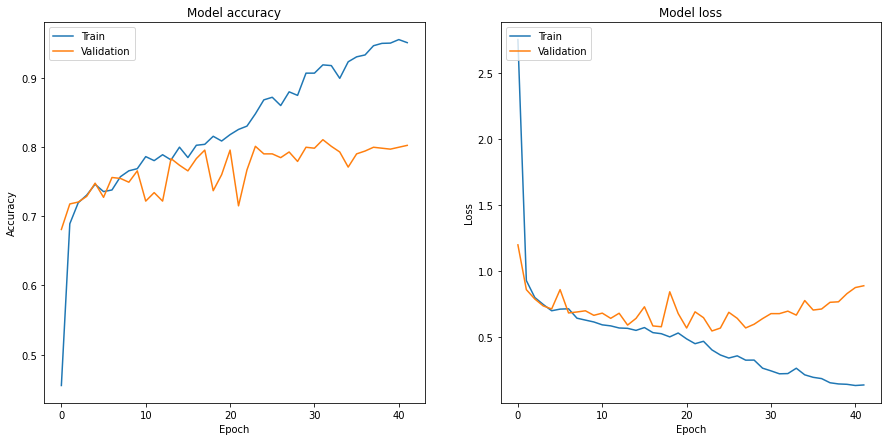

In [10]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Accuracy Plot')

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

In [11]:
model = load_model(filepath)
    
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)

In [12]:
y_score = model.predict(X_test)
y_pred = np.argmax(y_score,axis=1)
Y_test = np.argmax(y_test,axis=1)

In [13]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

acc = accuracy_score(Y_test,y_pred)
mpre = precision_score(Y_test,y_pred,average='macro')
mrecall = recall_score(Y_test,y_pred,average='macro')
mf1 = f1_score(Y_test,y_pred,average='macro')
kappa = cohen_kappa_score(Y_test,y_pred,weights='quadratic')
auc = roc_auc_score(Y_test, y_score, average='macro', multi_class='ovr')


print("Accuracy: ",round(acc*100,2))
print("Macro Precision: ",round(mpre*100,2))
print("Macro Recall: ",round(mrecall*100,2))
print("Macro F1-Score: ",round(mf1*100,2))
print("Quadratic Kappa Score: ",round(kappa*100,2))
print("ROC AUC Score: ",round(auc*100,2))

Accuracy:  81.04
Macro Precision:  69.09
Macro Recall:  59.57
Macro F1-Score:  61.53
Quadratic Kappa Score:  83.49
ROC AUC Score:  92.82


In [14]:
print(classification_report(Y_test,y_pred,digits=4,target_names = dr))

                  precision    recall  f1-score   support

           No DR     0.9468    0.9861    0.9661       361
         Mild DR     0.6032    0.5135    0.5547        74
     Moderate DR     0.7082    0.8250    0.7621       200
       Severe DR     0.6364    0.1795    0.2800        39
Proliferative DR     0.5600    0.4746    0.5138        59

        accuracy                         0.8104       733
       macro avg     0.6909    0.5957    0.6153       733
    weighted avg     0.7993    0.8104    0.7960       733



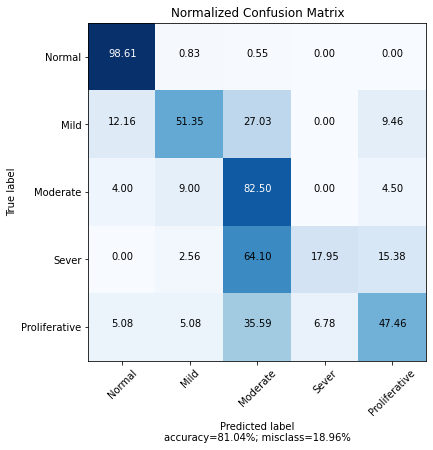

In [15]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}%; misclass={:0.2f}%'.format(accuracy*100, misclass*100))
    plt.savefig('Confusion_Matix.png')
    plt.show()
    
from sklearn import metrics
cm = metrics.confusion_matrix(Y_test,y_pred)

plot_confusion_matrix(cm , normalize = True, target_names = ['Normal','Mild','Moderate','Sever','Proliferative'], title = "Normalized Confusion Matrix", cmap='Blues')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


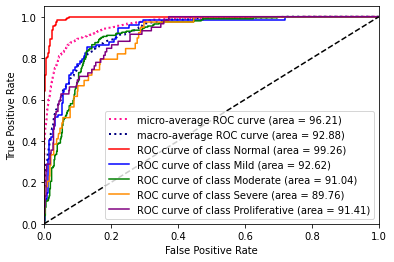

In [16]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

num_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]*100),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]*100),
         color='navy', linestyle=':', linewidth=2)

colors = cycle(['red','blue','green','darkorange', 'purple'])
classes = ['Normal','Mild','Moderate','Severe','Proliferative']
lw = 1.5

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]*100))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Retinopathy Diagnosis')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve.png')
plt.show()